# Soft_slide_Fe

dl 可以改 论文里是 1 5 10 30 60  目前是 1

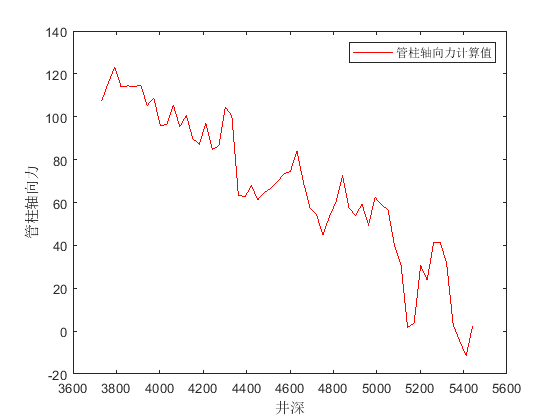

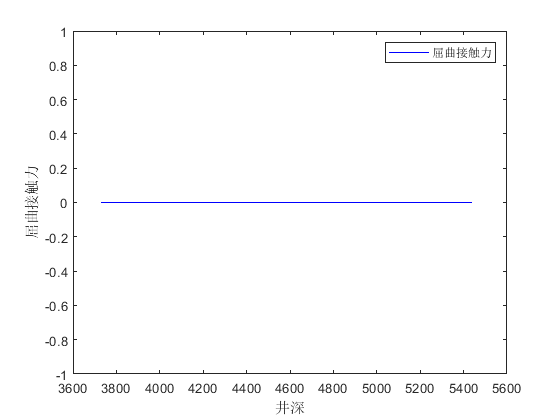

In [1]:
clc;clear;close all;
cd("D:\桌面\毕设\材料\摩阻扭矩\MATLAB")
trajectory_parameters = xlsread('LH11-1-B4H3.xlsx','轨道','A2:C10000');       % 读取轨道数据，依次为井深、井斜角、井斜方位角
pipe_parameters = xlsread('LH11-1-B4H3.xlsx','管柱数据','C5:G16');      % 读取套管柱数据，依次为内径，外径，接头外径，强度，长度
well_parameters = xlsread('LH11-1-B4H3.xlsx','井身结构','A2:C3');     % 读取井身结构数据，依次为1上层导管下入深度，2上层套管内径，3井眼直径
drill_parameters = xlsread('LH11-1-B4H3.xlsx','钻进数据','A2:G10000');       % 读取钻进数据，依次为1井深，2钻压，3钻头扭矩，4转速，5管柱运动速度，6排量，7钻井液密度
HK_TOR = xlsread('LH11-1-B4H3.xlsx','测量值','A2:C1000');       % 读取1井深2钩载3转盘扭矩
%% 滑动钻进
[alpha,k,kal,kph,tau,dk_ds,tz,nz,bz,dalpha_ds,dpha_ds]=traj_para_linear(trajectory_parameters);      % 自定义函数计算插值后的计算轨迹参数
[m,n] = size(drill_parameters );      % 钻进数据长度
depth_start = ceil(drill_parameters(1,1));        % 钻进开始井深
depth_end = floor(drill_parameters(m,1));         % 钻进开始井深
mu1 = 0.1566;
mu2 = 0.2697;
mu_cal = [mu1,mu2];
dL = 1;
for i = 1:m
    depth_i = drill_parameters(i,1);        % 钻进井深
    if depth_i <= 3717
        pipe_parameters_i = pipe_parameters(1:5,:);
        well_parameters_i = well_parameters(1,:);
    else
        pipe_parameters_i = pipe_parameters(6:10,:);
        well_parameters_i = well_parameters(2,:);
    end
    drill_parameters_i = drill_parameters(i,:);
    [Fe,wc] = drill_slide_soft_cal_Fe(depth_i,pipe_parameters_i,well_parameters_i,drill_parameters_i,alpha,k,tau,dk_ds,tz,nz,bz,mu_cal,dL,0);
    Hookload(i,:) = Fe(1)/1000;     % 记录相应深度处的大钩载荷值
    depth_cal(i,:) = depth_i;
    WC(i,:)=wc(1)/1000;
end
figure('Name','大钩载荷');

plot(depth_cal,Hookload,'r');
hold on;
xlabel('井深'); % x轴标签
ylabel('管柱轴向力');
legend("管柱轴向力计算值")
hold off;
figure('Name','屈曲接触力');
plot(depth_cal,WC,'b')
hold on;
xlabel('井深'); % x轴标签
ylabel('屈曲接触力');
legend("屈曲接触力")
hold off;


### 管柱轴向力

In [ ]:
function [Fe,wc] = drill_slide_soft_cal_Fe(depth_i,pipe_parameters_i,well_parameters_i,drill_parameters_i,alpha,k,tau,dk_ds,tz,nz,bz,mu_cal,dL,op)       % 大钩载荷计算函数
depth_i = floor(depth_i);           % 轴向力和扭矩计算井深
if depth_i == 0
    Fe = 0;
    wc = 0;
    return;
end
rpm = drill_parameters_i(4);        % 对应测深处的转速
vp = drill_parameters_i(5);         % 对应测深处的钻速
den_m = drill_parameters_i(7);      % 对应测深处的钻井液密度
if op == 0   % 旋转钻进
    wob = -drill_parameters_i(2);       % 对应测深处的钻压
    tob = drill_parameters_i(3);        % 对应测深处的钻头扭矩
    mu_op = 1;
elseif op == 1   % 旋转下入
    wob = -0;       % 对应测深处的钻压
    tob = 0;        % 对应测深处的钻头扭矩
    mu_op = 1;
elseif op == 2  % 旋转上提
    wob = -0;       % 对应测深处的钻压
    tob = 0;        % 对应测深处的钻头扭矩
    mu_op = -1;
end 
if mod(depth_i,dL) > 0
    depth_cal = [[0:dL:depth_i]';depth_i];	% 计算井深
else
    depth_cal = [0:dL:depth_i]';        % 计算井深
end
length_cal = length(depth_cal);      % 计算井深的数据长度
%%
E = 2.06*1.0e11;	% 钻杆弹性模量
g = 9.8;            % 重力加速度
den_s = 7850;       %钻柱的密度  kg/m3
di_array = pipe_parameters_i(:,1);        % 钻柱内径
do_array = pipe_parameters_i(:,2);        % 钻柱外径
dc_array = pipe_parameters_i(:,3);        % 钻柱接头外径
L = pipe_parameters_i(:,4);         % 钻柱长度
m_array = pipe_parameters_i(:,5);   % 线密度
%% 轴向力和扭矩
Fe(length_cal,:) = wob;        % 底部轴向力为wob
for j = length_cal:(-1):2    
    depth_j = depth_cal(j) + 1;         % 正计算井深+1
    if depth_j < well_parameters_i(1)	% well_parameters(1)为上一层套管深度,摩阻系数分段，套管和裸眼
        mu = mu_cal(1);     % 套管摩阻系数
        dw = well_parameters_i(2);      % 上层套管内径
    else
        mu = mu_cal(2);     % 裸眼摩阻系数
        dw = well_parameters_i(2);      % 裸眼井段直径
    end
    if depth_j > depth_i-L(5)
        do = do_array(5);   di = di_array(5);   dc = dc_array(5);   wp = m_array(5)*g;
    elseif depth_j > depth_i-L(5)-L(4)
        do = do_array(4);   di = di_array(4);   dc = dc_array(4);   wp = m_array(4)*g;
    elseif depth_j > depth_i-L(5)-L(4)-L(3)
        do = do_array(3);   di = di_array(3);   dc = dc_array(3);   wp = m_array(3)*g;
    elseif depth_j > depth_i-L(5)-L(4)-L(3)-L(2)
        do = do_array(2);   di = di_array(2);   dc = dc_array(2);   wp = m_array(2)*g;
    else
        do = do_array(1);   di = di_array(1);   dc = dc_array(1);   wp = m_array(1)*g;
    end
    wbp = (1-den_m/den_s)*wp;     % 单位长度钻柱浮重，假定管柱内外流体密度相同
    %%
    I = pi/64*(do^4-di^4);      % 截面惯性矩
    mu_d = mu;        %轴向摩阻系数
    mu_t = 0;       %周向摩阻系数
    if j == length_cal && mod(depth_i,dL)~=0
        dL_Mt_Fe = mod(depth_i,dL);
    else
        dL_Mt_Fe = dL;
    end
    %%
    wc(j,:) = ((-Fe(j)*k(depth_j)+wbp*nz(depth_j))^2+(wbp*bz(depth_j))^2)^0.5/(1+tau(depth_j)^2*mu_d^2*(do/2)^2)^0.5;        %接触力计算
    if wc(j,:) == 0
        wc(j,:) = 1e-6;
    end
    sin_theta(j,:)=(wbp*bz(depth_j)-(-mu_d*tau(depth_j)*do/2)*(-Fe(j)*k(depth_j)+wbp*nz(depth_j)))/(wc(j)*(1+(mu_d*tau(depth_j)*do/2)^2));      % 接触角正弦值
    cos_theta(j,:)=(-Fe(j)*k(depth_j)+wbp*nz(depth_j)-tau(depth_j)*mu_d*wc(j)*do/2*sin_theta(j))/wc(j);     %接触力余弦值
    %% 管柱屈曲判断
    l = 11.3;       % 套管单根长度
    ltj = 0.2;      % 接头长度
    de = do*(l-ltj)/l+dc*ltj/l;     % 管柱有效外直径
    re = (dw-de)/2;     % 有效外环隙
    if Fe(j) < 0 && abs(Fe(j)) >= 2*(E*I*wc(j)/re)^0.5 && j >2       % 正弦屈曲临界载荷判断
        if (abs(Fe(j)) >= 2*(2*2^0.5-1)*(E*I*wc(j)/re)^0.5 && alpha(j) > 1*pi/180) || (abs(Fe(j)) >= 5.55*(E*I*wbp^2)^0.5 && alpha(j) <= 1*pi/180)       % 螺旋屈曲临界载荷判断
            wc(j,:) = re*Fe(j)^2/(4*E*I);      % 螺旋屈曲接触力
        else
            wc(j,:) = re*Fe(j)^2/(8*E*I);      % 正弦屈曲接触力
        end
    end
    %% 迭代求解
    Fe(j-1) = Fe(j) - dL_Mt_Fe*(mu_d*wc(j)*(1-k(depth_j)*dc/2*cos_theta(j))-wbp*tz(depth_j));       % 迭代求解管柱轴向力                  
end
end